In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [49]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
file_path1 = '/content/drive/My Drive/X999/bbl_evictions_merged_covid.csv'

In [7]:
file_path2 = '/content/drive/My Drive/X999/svi_cleaned.csv'

In [54]:
bbl_evictions_df = pd.read_csv(file_path1)

In [11]:
svi_df = pd.read_csv(file_path2)

In [55]:
svi_simplified = svi_df[['FIPS', 'E_TOTPOP',
                        'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
                        'EP_POV150', 'EP_UNEMP', 'EP_NOHSDP', 'EP_UNINSUR',
                        'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_LIMENG',
                        'EP_NOVEH', 'EP_CROWD', 'EP_HBURD',
                        'EP_AFAM', 'EP_HISP', 'EP_ASIAN', 'EP_AIAN', 'EP_NHPI',
                        'EP_TWOMORE', 'EP_OTHERRACE', 'EP_MINRTY']]

In [56]:
svi_df.shape, svi_simplified.shape

((204, 156), (204, 26))

In [57]:
svi_simplified['EP_WHITE'] = 100 - svi_simplified['EP_MINRTY']

In [58]:
bbl_evictions_df.eviction_postcode.dtype, svi_simplified.FIPS.dtype

(dtype('int64'), dtype('int64'))

In [59]:
bbl_evictions_df['eviction_postcode'] = bbl_evictions_df['eviction_postcode'].astype(str)
svi_simplified['FIPS'] = svi_simplified['FIPS'].astype(str)

In [60]:
merged_df = pd.merge(bbl_evictions_df,
                    svi_simplified,
                    left_on='eviction_postcode',
                    right_on='FIPS',
                    how='left')

In [61]:
missing_svi = merged_df['RPL_THEMES'].isna().sum()
print(missing_svi/len(merged_df)*100,"% missing rows")

1.7513411170716315 % missing rows


In [62]:
if missing_svi > 0:
    missing_postcodes = merged_df[merged_df['RPL_THEMES'].isna()]['eviction_postcode'].unique()
    print(f"missing SVI data in these zipcodes: {missing_postcodes}")

missing SVI data in these zipcodes: ['11691' '11692' '11694' '11693' '11040']


In [63]:
missing_postcodes = merged_df[merged_df['RPL_THEMES'].isna()]['eviction_postcode'].unique()

In [64]:
merged_df_clean = merged_df[~merged_df['eviction_postcode'].isin(missing_postcodes)]
merged_df.shape, merged_df_clean.shape, len(merged_df) - len(merged_df_clean)

((6338, 67), (6227, 67), 111)

In [65]:
# merged_df_clean.columns

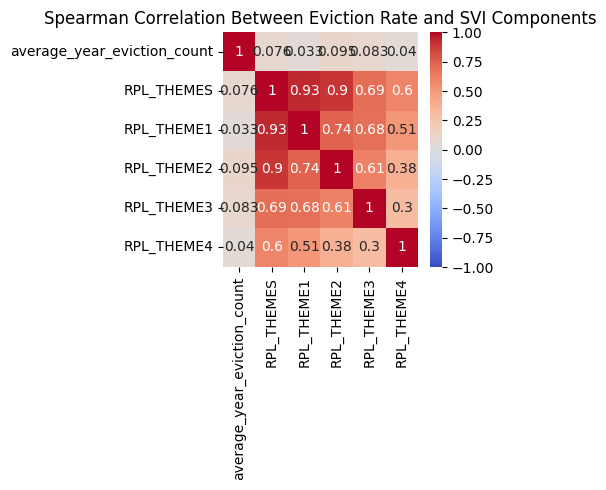

In [66]:
key_vars = ['average_year_eviction_count', 'RPL_THEMES', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4']
correlation_heatmap = merged_df_clean[key_vars].corr(method='spearman')

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_heatmap, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Between Eviction Rate and SVI Components')
plt.tight_layout()
plt.savefig('eviction_svi_correlation.png')

In [67]:
key_vars = ['average_year_eviction_count', 'RPL_THEMES', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4']
correlation_results = {}

for var in key_vars[1:]:
    correlation, p_value = stats.spearmanr(merged_df_clean['average_year_eviction_count'], merged_df_clean[var])
    correlation_results[var] = {'correlation': correlation, 'p_value': p_value}

for var, results in correlation_results.items():
    significance = "significant" if results['p_value'] < 0.05 else "not significant"
    print(f"correlation between eviction rate and {var}: r = {results['correlation']:.3f}, p = {results['p_value']:.4f} ({significance})")

correlation between eviction rate and RPL_THEMES: r = 0.076, p = 0.0000 (significant)
correlation between eviction rate and RPL_THEME1: r = 0.033, p = 0.0099 (significant)
correlation between eviction rate and RPL_THEME2: r = 0.095, p = 0.0000 (significant)
correlation between eviction rate and RPL_THEME3: r = 0.083, p = 0.0000 (significant)
correlation between eviction rate and RPL_THEME4: r = 0.040, p = 0.0014 (significant)


very weak correlations between SVI and evictions during Covid. 

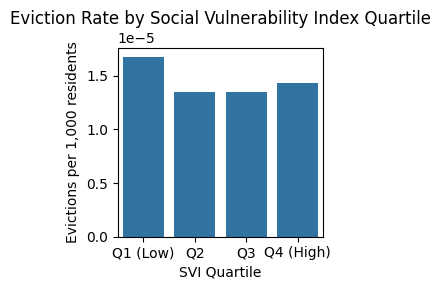

In [68]:
merged_df_clean['svi_quartile'] = pd.qcut(merged_df_clean['RPL_THEMES'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
quartile_analysis = merged_df_clean.groupby('svi_quartile').agg({
    'average_year_eviction_count': 'mean',
    'eviction_count': 'sum',
    'E_TOTPOP': 'sum'
}).reset_index()
quartile_analysis['total_eviction_rate'] = quartile_analysis['average_year_eviction_count'] / quartile_analysis['E_TOTPOP'] * 1000
plt.figure(figsize=(3, 3))
sns.barplot(x='svi_quartile', y='total_eviction_rate', data=quartile_analysis)
plt.title('Eviction Rate by Social Vulnerability Index Quartile')
plt.ylabel('Evictions per 1,000 residents')
plt.xlabel('SVI Quartile')
plt.tight_layout()
plt.savefig('eviction_by_svi_quartile.png')

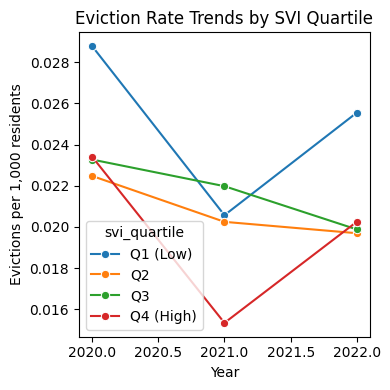

In [69]:
time_analysis = merged_df_clean.groupby(['year', 'svi_quartile']).agg({
    'average_year_eviction_count': 'sum',
    'E_TOTPOP': 'sum'
}).reset_index()
time_analysis['yearly_eviction_rate'] = time_analysis['average_year_eviction_count'] / time_analysis['E_TOTPOP'] * 1000

plt.figure(figsize=(4, 4))
sns.lineplot(x='year', y='yearly_eviction_rate', hue='svi_quartile', data=time_analysis, marker='o')
plt.title('Eviction Rate Trends by SVI Quartile')
plt.ylabel('Evictions per 1,000 residents')
plt.xlabel('Year')
plt.tight_layout()
plt.savefig('eviction_trends_svi.png')

during covid, svi is simply not does not have strong correlation with the evictions, likely due to the fact that people who had fairly stable socialeconomic power chose to leave nyc before an lease ended.